In [1]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    %pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

/tmp/ipykernel_66515/827511832.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Device: cuda:0
Number of workers: 16


### Data Augmentation for Contrastive Learning

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class `ContrastiveTransformations` below:

In [2]:
class ContrastiveTransformations(object):
    
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views
        
    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [3]:
# Augmentation, Random horizontal flip, crop-and-resize, color distortion, random grayscale and gaussian blur

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(), # 1
                                          transforms.RandomResizedCrop(size=96), # 2
                                          transforms.RandomApply([                  # 3
                                              transforms.ColorJitter(brightness=0.5, 
                                                                     contrast=0.5, 
                                                                     saturation=0.5, 
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2), # 4
                                          transforms.GaussianBlur(kernel_size=9), # 5
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [4]:
from CustomDataset.ShipDataset import ShipDataset


unlabeled_ship_data = ShipDataset(root="data", split='unlabeled', ul_img_pc=-1,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_ship_data = ShipDataset(root="data", split='train', l_img_pc=500,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2))
#dataset_val = ImageFolder(path_dataset_train, transform=ContrastiveTransformations(contrast_transforms, n_views=2))


Global seed set to 42


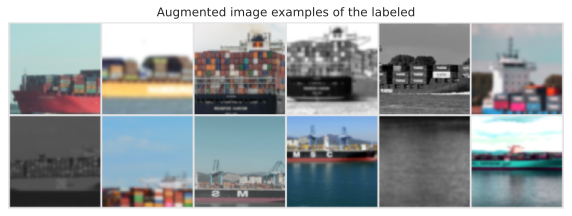

In [5]:
pl.seed_everything(42)
NUM_IMAGES = 6

imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in train_ship_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the labeled')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


Global seed set to 42


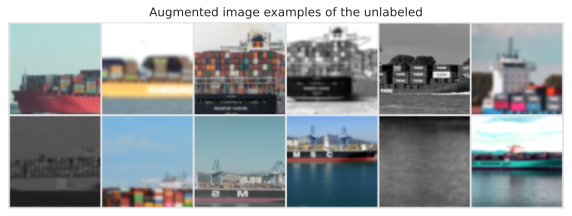

In [6]:
pl.seed_everything(42)
NUM_IMAGES = 6

imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_ship_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the unlabeled')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


Finally, before starting with our implementation of SimCLR, let's look at some example image pairs sampled with our augmentations:

In [7]:
print(len(unlabeled_ship_data), len(unlabeled_ship_data.labels))
print(len(train_ship_data), len(train_ship_data.labels))

print('\n')

print(type(unlabeled_ship_data[0]))
print(type(unlabeled_ship_data[0][0]))
print(type(unlabeled_ship_data[0][0][0]))
print(type(unlabeled_ship_data.labels))

print('\n')

print(unlabeled_ship_data[0][0][0].size())
print(unlabeled_ship_data[0][0][0])
print(len(unlabeled_ship_data[0][0][0]))

76470 76470
9000 9000


<class 'tuple'>
<class 'list'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>


torch.Size([3, 96, 96])
tensor([[[ 0.2863,  0.2863,  0.2863,  ...,  0.2706,  0.2784,  0.2784],
         [ 0.2863,  0.2863,  0.2863,  ...,  0.2706,  0.2784,  0.2784],
         [ 0.2863,  0.2863,  0.2863,  ...,  0.2706,  0.2706,  0.2706],
         ...,
         [ 0.2627,  0.2627,  0.2627,  ...,  0.3020,  0.2941,  0.2863],
         [ 0.2706,  0.2706,  0.2627,  ...,  0.3020,  0.2941,  0.2863],
         [ 0.2706,  0.2706,  0.2627,  ...,  0.3020,  0.2863,  0.2863]],

        [[ 0.4353,  0.4353,  0.4353,  ...,  0.4353,  0.4353,  0.4353],
         [ 0.4353,  0.4353,  0.4353,  ...,  0.4275,  0.4353,  0.4353],
         [ 0.4353,  0.4353,  0.4353,  ...,  0.4275,  0.4275,  0.4275],
         ...,
         [-0.2784, -0.2706, -0.2000,  ..., -0.2941, -0.2941, -0.3020],
         [-0.2784, -0.2706, -0.2078,  ..., -0.2941, -0.3020, -0.3098],
         [-0.2784, -0.2706, -0.2157,  ..., -0.3020, -0.3020, 

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion. Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

### SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR. At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$. Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch. The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$. The base network is usually a deep CNN as we have seen in e.g. [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) before, and is responsible for extracting a representation vector from the augmented data examples. In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$. The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer. Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset. The general setup is visualized below (figure credit - [Ting Chen et al.](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/simclr_network_setup.svg?raw=1" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor. The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task. This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks. Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Now that the architecture is described, let's take a closer look at how we train the model. As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch. SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al.](https://arxiv.org/abs/1807.03748) for contrastive learning. In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values. The loss can be formally written as:

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is. Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch. The similarity metric that is used in SimCLR is cosine similarity, as defined below:

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

The maximum cosine similarity possible is $1$, while the minimum is $-1$. In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [8]:
class SimCLR(pl.LightningModule):
    
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(pretrained=False, 
                                                   num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear 
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )
        # print(self.convnet)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]
        
    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)
        
        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()
        
        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], 
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())
        
        return nll
        
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')
        
    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

Alternatively to performing the validation on the contrastive learning loss as well, we could also take a simple, small downstream task, and track the performance of the base network $f(\cdot)$ on that. However, in this tutorial, we will restrict ourselves to the STL10 dataset where we use the task of image classification on STL10 as our test task.

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model. We will use the same training function setup as usual. For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch. This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [23]:
# def collate_fn(batch):
#     return tuple(zip(*batch))

def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'ShipSimCLR'),
                         gpus=1 if str(device)=='cuda:0' else 0,
                         enable_progress_bar=True,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'ShipSimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(unlabeled_ship_data, batch_size=batch_size, shuffle=True, 
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_ship_data, batch_size=batch_size, shuffle=False, 
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients. However, in our case, we experienced that a batch size of 256 was sufficient to get good results.

In [24]:
simclr_model = train_simclr(batch_size=256, 
                            hidden_dim=128, 
                            lr=5e-4, 
                            temperature=0.07, 
                            weight_decay=1e-4, 
                            max_epochs=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | convnet | ResNet | 11.5 M
-----------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.019    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

<class 'list'>
256
<class 'list'>
<class 'list'>
256
<class 'list'>
<class 'list'>
256
<class 'list'>
<class 'list'>
256
<class 'list'><class 'list'><class 'list'>


256256<class 'list'>

256<class 'list'>
<class 'list'>


<class 'list'>
<class 'list'>
256
<class 'list'>
<class 'list'>
256
<class 'list'>
<class 'list'>
256
<class 'list'><class 'list'>

<class 'list'>256

<class 'list'>256<class 'list'>


256<class 'list'>

<class 'list'>
<class 'list'>
256
<class 'list'><class 'list'>

256
<class 'list'>


/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception in thread Thread-134:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/venv/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/venv/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 297, in rebuild_storage_fd


IsADirectoryError: [Errno 21] Is a directory: '/home/dh/Workspace/SimCLR'

    fd = df.detach()
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 508, in Client
    answer_challenge(c, authkey)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 757, in answer_challenge
    response = connection.recv_bytes(256)        # reject large message
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
ConnectionResetError: [Errno 104] Connection reset by peer


To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

## Logistic Regression

After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data. A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features. In other words, we learn a single, linear layer that maps the representations to a class prediction. Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task. Further, we do not have to worry too much about overfitting since we have very few parameters that are trained. Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors. If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations. However, the way we implement it here is much more efficient and can be trained within a few seconds. Further, using data augmentations did not show any significant gain in this simple setup.

In [ ]:
class LogisticRegression(pl.LightningModule):
    
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[int(self.hparams.max_epochs*0.6), 
                                                                  int(self.hparams.max_epochs*0.8)], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]
        
    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss        
        
    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')
        
    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')
        
    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

The data we use is the training and test set of STL10. The training contains 500 images per class, while the test set has 800 images per class.

In [ ]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the Logistic Regression model.

In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
    
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]
    
    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [ ]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

Finally, we can write a training function as usual. We evaluate the model on the test set every 10 epochs to allow early stopping, but the low frequency of the validation ensures that we do not overfit too much on the test set.

In [ ]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None
    
    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False, 
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}
        
    return model, result

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets. Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class. This gives us an intuition on how well the representations learned by contrastive learning can be transfered to a image recognition task like this classification. First, let's define a function to create the intended sub-datasets from the full training set:

In [ ]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors]
    )
    return new_dataset

Next, let's run all models. Despite us training 6 models, this cell could be run within a minute or two without the pretrained models. 

In [ ]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=10,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results

Finally, let's plot the results.

In [ ]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

As one would expect, the classification performance improves the more data we have. However, with only 10 images per class, we can already classify more than 60% of the images correctly. This is quite impressive, considering that the images are also higher dimensional than e.g. CIFAR10. With the full dataset, we achieve an accuracy of 81%. The increase between 50 to 500 images per class might suggest a linear increase in performance with an exponentially larger dataset. However, with even more data, we could also finetune $f(\cdot)$ in the training process, allowing for the representations to adapt more to the specific classification task given.

To set the results above into perspective, we will train the base network, a ResNet-18, on the classification task from scratch.

## Baseline

As a baseline to our results above, we will train a standard ResNet-18 with random initialization on the labeled training set of STL10. The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training. The implementation of the model is straightforward since the ResNet architecture is provided in the torchvision library.

In [ ]:
class ResNet(pl.LightningModule):

    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(
            pretrained=False, num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[int(self.hparams.max_epochs*0.7), 
                                                                  int(self.hparams.max_epochs*0.9)], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size. To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur. Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification. Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations. Similarly, we restrict the resizing operation before cropping to the max. 125% of its original resolution, instead of 1250% as done in SimCLR. This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object. Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

In [ ]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)

The training function for the ResNet is almost identical to the Logistic Regression setup. Note that we allow the ResNet to perform validation every 2 epochs to also check whether the model overfits strongly in the first iterations or not.

In [ ]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=2)
    trainer.logger._default_hp_metric = None
    
    # Data loaders
    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False, 
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) # To be reproducable
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}
        
    return model, result

Finally, let's train the model and check its results:

In [ ]:
resnet_model, resnet_result = train_resnet(batch_size=64,
                                           num_classes=10,
                                           lr=1e-3,
                                           weight_decay=2e-4,
                                           max_epochs=100)
print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['test']:4.2f}%")

The ResNet trained from scratch achieves 73.31% on the test set. This is almost 8% less than the contrastive learning model, and even slightly less than SimCLR achieves with 1/10 of the data. This shows that self-supervised, contrastive learning provides considerable performance gains by leveraging large amounts of unlabeled data when little labeled data is available.